# Desempeño de modelo MedSAM en dataset PET/CT con anotaciones de radiólogos HCUCH
- Se evaluó el desempeño de segmentación (dice=mean +- std) del modelo MedSAM en un subconjunto de 9 estudios CT tomados del dataset PET/CT de Gatidis, con anotaciones realizadas por 2 médicos radiólogos del HCUCH. Los resultados se agrupan en función del radiólogo anotador (Gonzalo, Maria Fernanda) y de la normalización aplicada a los datos (default, abdomen):
    - Gonzalo-default: 0.55 +- 0.29
    - Gonzalo-abdomen: 0.66 +- 0.27
    - Maria Fernanda-default: 0.51 +- 0.27
    - Maria Fernanda-abdomen: 0.57 +- 0.3
- Se observa una tendencia de un desempeño de segmentación bajo (dice < 0.5) cuando el bounding box es pequeño. Estos casos impactan negativamente en el dice promedio final para cada dataset evaluado. 

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pathlib import Path
from itertools import product

In [2]:
path_to_performances = {
    "Gonzalo_default": {
        "annotator": "Gonzalo",
        "window": "default",
        "path": "resources/performance_Gonzalo_default.json"
    },
    "Gonzalo_abdomen": {
        "annotator": "Gonzalo",
        "window": "abdomen",
        "path": "resources/performance_Gonzalo_abdomen.json"
    },
    "MariaFernanda_default": {
        "annotator": "Maria Fernanda",
        "window": "default",
        "path": "resources/performance_MariaFernanda_default.json"
    },
    "MariaFernanda_abdomen": {
        "annotator": "Maria Fernanda",
        "window": "abdomen",
        "path": "resources/performance_MariaFernanda_abdomen.json"
    }
}

In [3]:
performances_df = pd.DataFrame()
for value in path_to_performances.values():
    with open(value["path"], 'r') as file:
        performance = json.load(file)
    performance = pd.DataFrame(performance)
    performance['annotator'] = value['annotator']
    performance['window'] = value['window']
    performances_df = pd.concat([performances_df, performance])
performances_df.reset_index(inplace=True, drop=True)

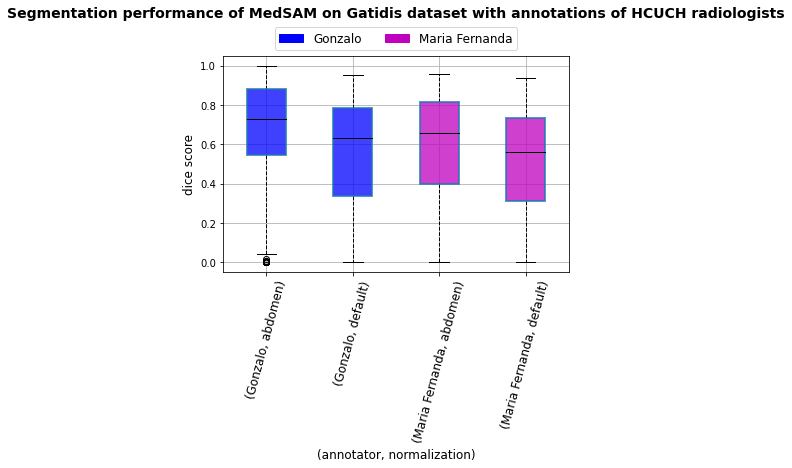

In [4]:
normalizations_count = len(performances_df['window'].unique())
annotator_colors = ['b', 'm']
colors = normalizations_count * [annotator_colors[0]] +  normalizations_count * [annotator_colors[1]]
boxplot = performances_df.boxplot(
    column='dice_score',
    by=['annotator', 'window'],
    return_type='both',
    patch_artist=True,
    medianprops={'color':'k', 'linewidth': 1},
    whiskerprops={'linestyle': '--'}
)
for _, (_, row) in boxplot.items():
    for color, box in zip(colors, row['boxes']):
        box.set_facecolor(color)
        box.set_alpha(0.75)
        box.set_linewidth(2)
handles = [mpatches.Patch(color=color) for color in annotator_colors]
labels = ['Gonzalo', 'Maria Fernanda']
plt.legend(
    handles=handles,
    labels=labels,
    loc='upper center',
    ncol=len(colors),
    bbox_to_anchor=(0.5, 1.16),
    fontsize=12
)
plt.suptitle('')
plt.title(
    'Segmentation performance of MedSAM on Gatidis dataset with annotations of HCUCH radiologists',
    x=0.5,
    y=1.15,
    fontweight='bold',
    fontsize=14
)
plt.ylabel('dice score', fontsize=12)
plt.xlabel('(annotator, normalization)', fontsize=12)
plt.xticks(rotation=75, fontsize=12)
#plt.savefig('MedSAM_performance_Gatidis_HCUCH_annotations.png', bbox_inches='tight')
plt.show()

In [5]:
performances_df.groupby(['annotator', 'window']).describe()['dice_score']

count      mean       std  min       25%       50%  \
annotator      window                                                        
Gonzalo        abdomen  649.0  0.658064  0.271482  0.0  0.544413  0.730159   
               default  649.0  0.550428  0.286747  0.0  0.338462  0.631579   
Maria Fernanda abdomen  893.0  0.566407  0.298944  0.0  0.400000  0.658031   
               default  893.0  0.509665  0.272967  0.0  0.312500  0.562500   

                             75%       max  
annotator      window                       
Gonzalo        abdomen  0.880952  1.000000  
               default  0.786415  0.951491  
Maria Fernanda abdomen  0.813419  0.959436  
               default  0.734628  0.939215

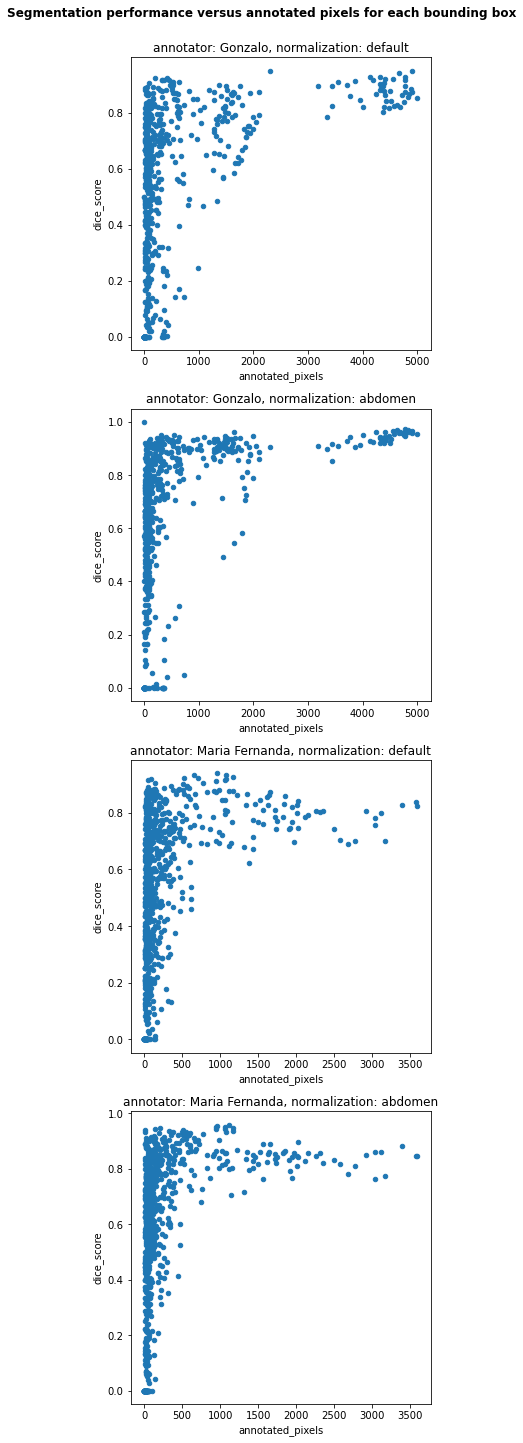

In [6]:
unique_annotators = performances_df['annotator'].unique()
unique_windows = performances_df['window'].unique()
combs = list(product(unique_annotators, unique_windows))
_, ax = plt.subplots(len(combs), 1, figsize=(5, 20))
plt.suptitle(
    "Segmentation performance versus annotated pixels for each bounding box",
    fontweight='bold',
    y=1.0
)
for idx, (annotator, window) in enumerate(combs):
    performances_df[
        (performances_df['annotator'] == annotator) &
        (performances_df['window'] == window)
    ].plot.scatter(
        x='annotated_pixels',
        y='dice_score',
        ax=ax[idx]
    )
    ax[idx].set_title(f"annotator: {annotator}, normalization: {window}")
plt.tight_layout()
plt.show()